## Making Predictions

In [ ]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.6/914.6 kB 29.3 MB/s eta 0:00:00


In [ ]:
!pip install -q git+https://github.com/ultralytics/CLIP.git

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.4 MB/s eta 0:00:00


In [ ]:
import os
os.makedirs("target", exist_ok=True)
os.makedirs("input", exist_ok=True)

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!sudo locale-gen en_US.UTF-8  # Generates the UTF-8 locale
!sudo update-locale LANG=en_US.UTF-8  # Sets the default locale to UTF-8
### downloading pretrained COCO model ---> https://github.com/ultralytics/ultralytics?tab=readme-ov-file
!wget -q https://github.com/ultralytics/assets/releases/download/v8.3.0/yolo11s-seg.pt

Generating locales (this might take a while)...
  en_US.UTF-8... done
Generation complete.



0: 448x640 1 person, 1 dog, 1 bowl, 56.8ms
Speed: 9.5ms preprocess, 56.8ms inference, 725.1ms postprocess per image at shape (1, 3, 448, 640)


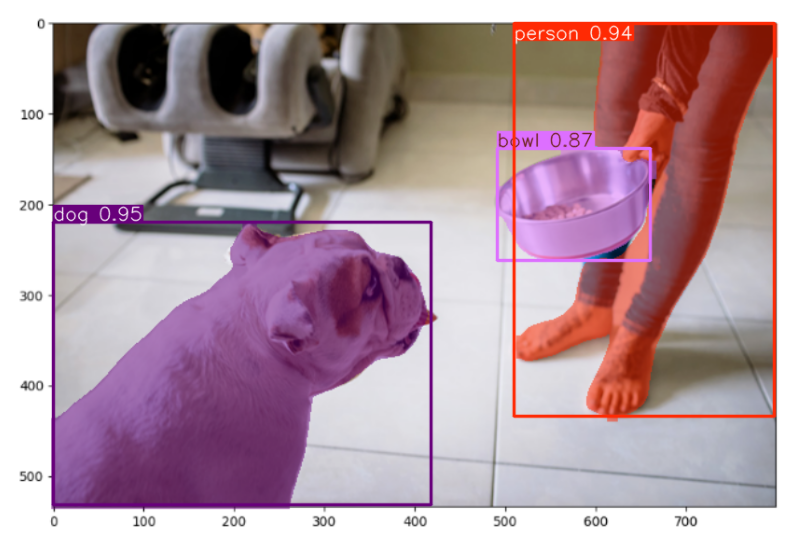

In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

model_path ="/content/yolo11s-seg.pt"
image_path = "/content/dog.jpg"

model = YOLO(model_path).to("cuda")

# Load the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Run inference
results = model(image)

# Plot the segmented image
plt.figure(figsize=(10, 10))
plt.imshow(results[0].plot())  # Plot the results
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
results[0].masks[0].data.shape

torch.Size([1, 448, 640])

In [ ]:
import cv2
import numpy as np
import torch
import math
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
def preprocess_image(image_path, target_size=(640, 640), data_split=None):
    """
    Preprocess the image by resizing it and saving it to a target directory.
    """
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    image = image / 255.0
    image = (image * 255).astype(np.uint8)

    path = str(image_path).split("/")[-1]
    if data_split is None:
        output_path = f"target/{path}"
    else:
        output_path = f"target/{data_split}/{path}"
    cv2.imwrite(output_path, image)
    return output_path

In [ ]:
def get_center(bbox):
    """
    Calculate the center of a bounding box.
    """
    x_min, y_min, x_max, y_max = bbox[0], bbox[1], bbox[2], bbox[3]
    center_x = (x_min + x_max) / 2
    center_y = (y_min + y_max) / 2
    return center_x, center_y

In [ ]:
def make_inference(img_path, model_path="yolo11s-seg.pt", conf=0.30):
    """
    Perform inference using YOLO11s-Seg and return masks and bounding boxes.
    """
    model = YOLO(model_path).to("cuda")

    # Read and resize the image
    img = cv2.imread(img_path)

    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    img_resized = cv2.resize(img, (640, 640))

    # Perform inference
    # higher conf so that high-confidence detections are kept,
    # resulting in fewer but potentially more accurate detections
    results = model(img_resized,conf = conf)

    # Plot the segmented image
    plt.figure(figsize=(5, 5))
    plt.imshow(results[0].plot())  # Plot the results
    plt.axis('off')  # Hide axes
    plt.show()

    # Extract masks and bounding boxes
    masks = results[0].masks.data if results[0].masks is not None else None
    boxes = results[0].boxes.xyxy.cpu().numpy() if results[0].boxes is not None else None

    return masks, boxes

In [ ]:
def infuse_image_mask(image_path, X=0.5, Y=0.5, model_path="yolo11s-seg.pt", class_name=None, data_split=None):
    """
    Infuse a mask into the image by blacking out the region corresponding to the mask.
    """
    try:
        # Convert X and Y to pixel coordinates for a 640x640 image
        X = math.floor(X * 640)
        Y = math.floor(Y * 640)

        # Preprocess the image and get its path
        target_path = preprocess_image(image_path, data_split=data_split)

        # Perform inference to get masks and bounding boxes
        masks, boxes = make_inference(target_path, model_path)

        # Check if masks or boxes are valid before proceeding
        if masks is None or boxes is None:
            raise ValueError("Inference returned no masks or bounding boxes.")

        # Load the preprocessed image
        img = plt.imread(target_path)
        _img = img.copy()

        # Iterate through each bounding box to find which one contains (X, Y)
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = box

            # Check if (X, Y) is within this bounding box
            if x1 <= X <= x2 and y1 <= Y <= y2:
                # Use the corresponding mask
                mask = masks[i].cpu().numpy()
                _mask = np.where(mask > 0, 1, 0)  # Create binary mask

                # Black out the pixels in the original image using the mask
                _img[_mask == 1] = [0, 0, 0]

                # Save the modified image
                path = str(image_path).split("/")[-1]
                if data_split:
                    input_path = f"input/{data_split}/{path}"
                else:
                    input_path = f"input/{path}"

                plt.imsave(input_path, _img)
                return input_path, target_path

        print("No matching bounding box found for the given coordinates.")
        return None, None

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None


0: 640x640 1 person, 1 dog, 2 bowls, 1 chair, 20.5ms
Speed: 2.0ms preprocess, 20.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


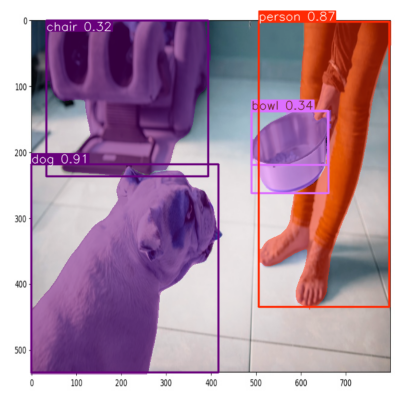

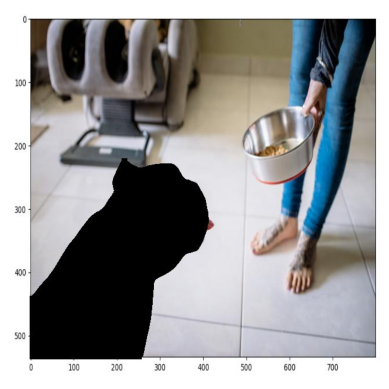

In [ ]:
# Example usage of infuse_image_mask with YOLO11s-Seg
input_path, target_path = infuse_image_mask("/content/dog.jpg", X=0.5, Y=0.5, model_path="/content/yolo11s-seg.pt", class_name="dog", data_split=None)

if input_path:
    img = Image.open(input_path)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
else:
    print("No mask found or error occurred.")

In [ ]:
# def make_inference(img_path, X=300, Y=300, model_path = "/content/yolo11s-seg.pt", class_name=None):
#     model = YOLO(model_path).to("cuda")
#     results = model(img_path)
#     print(len(results[0].masks))
#     return results[0].masks[0].data

In [ ]:
# from PIL import Image
# input_path, target_path = infuse_image_mask("/content/people2.jpg", 0.5, 0.5, "/content/yolo11s-seg.pt", "dog", None)
# img = Image.open(input_path)
# plt.imshow(img)
# plt.axis("off")
# plt.show()

## Loading Dataset

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.0/943.0 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 11.5 MB/s eta 0:00:00

In [ ]:
classes = [
    # Urban and Building Elements
    "Skyscraper", "Door handle", "Traffic light", "Stop sign", "Fire hydrant",

    # Vehicles and Transportation
    "Car", "Bus", "Truck", "Motorcycle", "Bicycle wheel", "Airplane", "Train",

    # Electronics and Appliances
    "Computer keyboard", "Laptop", "Mobile phone", "Microwave oven", "Washing machine",

    # Furniture and Home Objects
    "Couch", "Clock", "Picture frame", "Pillow", "Vase",

    # Kitchen and Food
    "Refrigerator", "Oven", "Knife", "Spoon", "Bowl",

    # Food Items
    "Apple", "Banana", "Broccoli", "Carrot", "Pizza", "Hamburger", "Cake",

    # Animals
    "Dog", "Cat", "Bird", "Horse", "Elephant", "Giraffe", "Fish",

    # People and Body Parts
    "Person", "Man", "Woman", "Boy", "Girl", "Human body", "Human ear", "Human mouth",

    # Clothing and Accessories
    "Shirt", "Trousers", "Dress", "Hat", "Handbag", "Suitcase",

    # Sports and Recreation
    "Ball", "Tennis racket", "Skateboard", "Surfboard",

    # Nature and Plants
    "Flower", "Tree", "Rose", "Pumpkin", "Mushroom",

    # Tools and Utilities
    "Scissors", "Screwdriver", "Hammer", "Flashlight", "Light switch",

    # Miscellaneous
    "Book", "Pencil case", "Teddy bear", "Candle"
]

print(f"Total number of classes: {len(classes)}")

Total number of classes: 73


In [ ]:
import fiftyone.utils.openimages as fouo
import fiftyone as fo
import fiftyone.zoo as foz

# Get the available segmentation classes for Open Images V6
segmentation_classes = fouo.get_segmentation_classes(version="v6")

# Print the list of segmentation classes
print("Available segmentation classes:")
for cls in segmentation_classes:
    print(cls)

# Print the total number of segmentation classes
print(f"\nTotal number of segmentation classes: {len(segmentation_classes)}")


Available segmentation classes:
Adhesive tape
Aircraft
Airplane
Alarm clock
Alpaca
Ambulance
Apple
Armadillo
Artichoke
Axe
Backpack
Bagel
Balance beam
Ball
Balloon
Banana
Band-aid
Barge
Barrel
Baseball bat
Baseball glove
Bat (Animal)
Beaker
Bear
Beer
Bell pepper
Belt
Bicycle wheel
Billiard table
Binoculars
Bird
Blue jay
Bomb
Book
Boot
Bottle
Bottle opener
Bowl
Box
Boy
Bread
Briefcase
Broccoli
Bronze sculpture
Brown bear
Bull
Burrito
Bus
Bust
Cabbage
Cake
Calculator
Camel
Camera
Canary
Candle
Canoe
Cantaloupe
Car
Carnivore
Carrot
Cat
Cattle
Cello
Cheese
Cheetah
Chest of drawers
Chicken
Chisel
Chopsticks
Christmas tree
Clock
Clothing
Cocktail
Cocktail shaker
Coffee
Coffee cup
Coin
Common fig
Common sunflower
Computer keyboard
Computer mouse
Cookie
Cooking spray
Corded phone
Couch
Cowboy hat
Cricket ball
Crocodile
Croissant
Cucumber
Dagger
Diaper
Dice
Digital clock
Dog
Dog bed
Dolphin
Door handle
Doughnut
Dress
Drill (Tool)
Drink
Drinking straw
Duck
Dumbbell
Eagle
Elephant
Envelope
Eraser

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/openImagev6

/content/drive/.shortcut-targets-by-id/1H7pRCYg-5ym8c5VB8DQL70MtUHyKZIP1/openImagev6


In [ ]:
!pip install -q fiftyone

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz

# classes = ['Chair', 'Desk', 'Wardrobe', 'Bench', 'Sofa', 'Bed', 'Table',
#            'Closet', 'Book', 'Ceiling fan', 'Refrigerator', 'Washing machine',
#            'Kettle', 'Tablet computer', 'Mobile phone', 'Bottle',
#            'Boy', 'Girl', 'Man', 'Woman', 'Television', 'Computer monitor',
#            'Computer keyboard', 'Laptop', 'Stationary bicycle', 'Goat',
#            'Camel', 'Cattle', 'Dog', 'Cat', 'Backpack', 'Suitcase', 'Umbrella',
#            'Watch', 'Truck', 'Bus', 'Ambulance', 'Car', 'Motorcycle']

# classes = ['Cat', 'Dog']

num_classes = len(classes)
print(num_classes)
samples_per_class = 100

multiples = {
    "train": 6,
    "validation": 3,
    "test": 1
}
fo.config.dataset_zoo_dir = "/content/drive/MyDrive/openImagev6"

for split in ["train", "validation", "test"]:
    dataset = foz.load_zoo_dataset(
        "open-images-v6",
        split= split,
        label_types=["segmentations"],
        classes=classes,
        max_samples=num_classes * samples_per_class * multiples[split],
        shuffle=True,
        seed=51,
    )

73


INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/content/drive/MyDrive/openImagev6/open-images-v6/train' if necessary


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv' to '/content/drive/MyDrive/openImagev6/open-images-v6/train/metadata/image_ids.csv'


 100% |██████|    4.8Gb/4.8Gb [10.6s elapsed, 0s remaining, 553.2Mb/s]      


INFO:eta.core.utils: 100% |██████|    4.8Gb/4.8Gb [10.6s elapsed, 0s remaining, 553.2Mb/s]      


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv' to '/content/drive/MyDrive/openImagev6/open-images-v6/train/metadata/classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/classes-segmentation.txt' to '/content/drive/MyDrive/openImagev6/open-images-v6/train/metadata/segmentation_classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json' to '/tmp/tmpxr60t_79/metadata/hierarchy.json'


No segmentations exist for classes ['Refrigerator', 'Tree']
You can view the available segmentation classes via `get_segmentation_classes()`


You can view the available segmentation classes via `get_segmentation_classes()`


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-annotations-object-segmentation.csv' to '/content/drive/MyDrive/openImagev6/open-images-v6/train/labels/segmentations.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-d.zip' to '/content/drive/MyDrive/openImagev6/open-images-v6/train/labels/masks/D.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-f.zip' to '/content/drive/MyDrive/openImagev6/open-images-v6/train/labels/masks/F.zip'


In [ ]:
import pandas as pd
val_annotation_df = pd.read_csv("/root/fiftyone/open-images-v6/validation/labels/detections.csv")
# val_annotation_df.head()
train_annotation_df = pd.read_csv("/root/fiftyone/open-images-v6/train/labels/detections.csv")
# train_annotation_df.head()
test_annotation_df = pd.read_csv("/root/fiftyone/open-images-v6/test/labels/detections.csv")
test_annotation_df.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000026e7ee790996,xclick,/m/07j7r,1,0.071875,0.145313,0.206250,0.391667,0,1,1,0,0
1,000026e7ee790996,xclick,/m/07j7r,1,0.439063,0.571875,0.264583,0.435417,0,1,1,0,0
2,000026e7ee790996,xclick,/m/07j7r,1,0.668750,1.000000,0.000000,0.552083,0,1,1,0,0
3,000062a39995e348,xclick,/m/015p6,1,0.206208,0.849224,0.154639,1.000000,0,0,0,0,0
4,000062a39995e348,xclick,/m/05s2s,1,0.137472,0.376940,0.000000,0.883652,1,1,0,0,0


In [ ]:
id_class_df = pd.read_csv("/root/fiftyone/open-images-v6/validation/metadata/classes.csv",
                          header = None,
                          names = ['LabelName', 'DisplayName'])
id_class_df.head()

,LabelName,DisplayName
0,/m/011k07,Tortoise
1,/m/011q46kg,Container
2,/m/012074,Magpie
3,/m/0120dh,Sea turtle
4,/m/01226z,Football


In [ ]:
len(id_class_df)

601

In [ ]:
filtered_id_class_df = id_class_df[id_class_df['DisplayName'].isin(classes)]
filtered_id_class_df.reset_index(drop=True, inplace=True)
filtered_id_class_df.head()

,LabelName,DisplayName
0,/m/01yrx,Cat
1,/m/0bt9lr,Dog


In [ ]:
filtered_val_annotation_df = val_annotation_df[val_annotation_df['LabelName'].isin(filtered_id_class_df['LabelName'])]
filtered_train_annotation_df = train_annotation_df[train_annotation_df['LabelName'].isin(filtered_id_class_df['LabelName'])]
filtered_test_annotation_df = test_annotation_df[test_annotation_df['LabelName'].isin(filtered_id_class_df['LabelName'])]
filtered_val_annotation_df.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
66,0007cebe1b2ba653,xclick,/m/0bt9lr,1,0.420354,0.793510,0.181416,0.721239,0,0,0,0,0
73,0007d6cf88afaa4a,xclick,/m/0bt9lr,1,0.173427,0.902098,0.216783,0.941725,0,0,0,0,0
74,0008e425fb49a2bf,xclick,/m/0bt9lr,1,0.226103,0.715074,0.111702,0.934397,0,0,0,0,0
98,000c4d66ce89aa69,xclick,/m/0bt9lr,1,0.220217,0.864621,0.083032,0.924188,0,0,0,0,0
247,0022d0ab1e1347ab,xclick,/m/0bt9lr,1,0.048438,1.000000,0.170833,1.000000,0,1,0,0,0


In [ ]:
import os
val_image_id = os.listdir('/root/fiftyone/open-images-v6/validation/data')
val_image_id = [x.split('.')[0] for x in val_image_id]
train_image_id = os.listdir('/root/fiftyone/open-images-v6/train/data')
train_image_id = [x.split('.')[0] for x in train_image_id]
test_image_id = os.listdir('/root/fiftyone/open-images-v6/test/data')
test_image_id = [x.split('.')[0] for x in test_image_id]
len(val_image_id), len(train_image_id), len(test_image_id)

(400, 1000, 600)

In [ ]:
val_image_id[:5], train_image_id[:5], test_image_id[:5]

(['e1ad57f657f7a7eb',
  '553f5edfbf2780df',
  'd62fd9eb0ddf9a13',
  'f35353824f7e1192',
  '828730b85c55e4ba'],
 ['9ba46169f5c3d706',
  '41bc22319f51e903',
  '56e02c53f180992d',
  '4f1eb39df8e57fc1',
  '5acd764677785628'],
 ['38abc2ecd1d7fc6a',
  '8df7b61ad2f68296',
  'faeb39c43e169b0f',
  '4222e2b560f902ff',
  '4c49da849f53fe7e'])

In [ ]:
filtered_val_annotation_df = filtered_val_annotation_df[filtered_val_annotation_df['ImageID'].isin(val_image_id)]
filtered_train_annotation_df = filtered_train_annotation_df[filtered_train_annotation_df['ImageID'].isin(train_image_id)]
filtered_test_annotation_df = filtered_test_annotation_df[filtered_test_annotation_df['ImageID'].isin(test_image_id)]
filtered_val_annotation_df.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
73,0007d6cf88afaa4a,xclick,/m/0bt9lr,1,0.173427,0.902098,0.216783,0.941725,0,0,0,0,0
1288,01125dd72c09cc5a,xclick,/m/0bt9lr,1,0.530556,0.755556,0.754167,0.904167,1,0,0,0,0
2612,01f5c22d73bfed30,xclick,/m/0bt9lr,1,0.145313,0.875000,0.027083,0.837500,1,0,1,0,0
3990,032518c7e3660911,xclick,/m/0bt9lr,1,0.310937,0.606250,0.408333,0.747917,0,0,0,0,0
4450,039beb511fd1e7f7,xclick,/m/01yrx,1,0.004680,0.472699,0.141962,0.891440,0,0,0,0,0


In [ ]:
filtered_val_annotation_df = filtered_val_annotation_df[['ImageID', 'LabelName', 'XMin', 'XMax', 'YMin', 'YMax']]
filtered_val_annotation_df.reset_index(drop=True, inplace=True)
filtered_train_annotation_df = filtered_train_annotation_df[['ImageID', 'LabelName', 'XMin', 'XMax', 'YMin', 'YMax']]
filtered_train_annotation_df.reset_index(drop=True, inplace=True)
filtered_test_annotation_df = filtered_test_annotation_df[['ImageID', 'LabelName', 'XMin', 'XMax', 'YMin', 'YMax']]
filtered_test_annotation_df.reset_index(drop=True, inplace=True)
filtered_val_annotation_df.head()

,ImageID,LabelName,XMin,XMax,YMin,YMax
0,0007d6cf88afaa4a,/m/0bt9lr,0.173427,0.902098,0.216783,0.941725
1,01125dd72c09cc5a,/m/0bt9lr,0.530556,0.755556,0.754167,0.904167
2,01f5c22d73bfed30,/m/0bt9lr,0.145313,0.875000,0.027083,0.837500
3,032518c7e3660911,/m/0bt9lr,0.310937,0.606250,0.408333,0.747917
4,039beb511fd1e7f7,/m/01yrx,0.004680,0.472699,0.141962,0.891440


In [ ]:
missing_val_image_ids = set(filtered_val_annotation_df['ImageID']) - set(val_image_id)
missing_train_image_ids = set(filtered_train_annotation_df['ImageID']) - set(train_image_id)
missing_test_image_ids = set(filtered_test_annotation_df['ImageID']) - set(test_image_id)
print(len(missing_val_image_ids), len(missing_train_image_ids), len(missing_test_image_ids))

0 0 0


In [ ]:
print(len(filtered_val_annotation_df), len(val_annotation_df))
print(len(filtered_train_annotation_df), len(train_annotation_df))
print(len(filtered_test_annotation_df), len(test_annotation_df))

496 303980
1610 14610229
712 937327


In [ ]:
len(filtered_id_class_df)

2

In [ ]:
filtered_val_annotation_df.head()

,ImageID,LabelName,XMin,XMax,YMin,YMax
0,0007d6cf88afaa4a,/m/0bt9lr,0.173427,0.902098,0.216783,0.941725
1,01125dd72c09cc5a,/m/0bt9lr,0.530556,0.755556,0.754167,0.904167
2,01f5c22d73bfed30,/m/0bt9lr,0.145313,0.875000,0.027083,0.837500
3,032518c7e3660911,/m/0bt9lr,0.310937,0.606250,0.408333,0.747917
4,039beb511fd1e7f7,/m/01yrx,0.004680,0.472699,0.141962,0.891440


In [ ]:
filtered_train_annotation_df.head()

,ImageID,LabelName,XMin,XMax,YMin,YMax
0,000aa552a9d80891,/m/01yrx,0.000000,0.772500,0.000000,0.998889
1,001ed4dc220ca57f,/m/0bt9lr,0.096250,0.492500,0.050645,0.511050
2,00341202d021b919,/m/0bt9lr,0.000000,0.993506,0.252174,0.997826
3,00341202d021b919,/m/01yrx,0.607143,0.857143,0.110870,0.536957
4,00341202d021b919,/m/0bt9lr,0.000000,0.733766,0.482609,0.704348


In [ ]:
filtered_test_annotation_df.head()

,ImageID,LabelName,XMin,XMax,YMin,YMax
0,00567dcce4a5f7d9,/m/01yrx,0.070312,1.000000,0.050000,0.739583
1,016132490f8ec495,/m/0bt9lr,0.156250,0.981250,0.000000,0.846875
2,022e89969b239b63,/m/0bt9lr,0.131455,0.884194,0.225000,0.875000
3,028363ddd78950c6,/m/0bt9lr,0.000000,0.987500,0.091667,1.000000
4,02c65fc2dddbd85f,/m/0bt9lr,0.000000,0.785137,0.018182,0.997980


In [ ]:
filtered_val_annotation_df.to_csv('val_annotations.csv', index=False)
filtered_train_annotation_df.to_csv('train_annotations.csv', index=False)
filtered_test_annotation_df.to_csv('test_annotations.csv', index=False)
filtered_id_class_df.to_csv('classes.csv', index=False)

In [ ]:
import pandas as pd

# Load classes CSV
classes = pd.read_csv('classes.csv')

# Create a dictionary to map LabelName to class index
class_mapping = {row['LabelName']: idx for idx, row in classes.iterrows()}
print(class_mapping)

{'/m/01yrx': 0, '/m/0bt9lr': 1}


In [ ]:
import pandas as pd

# Load classes CSV
classes = pd.read_csv('classes.csv')

# Create a dictionary to map LabelName to class index
idx_mapping = {idx: row['DisplayName'] for idx, row in classes.iterrows()}
print(idx_mapping)

{0: 'Cat', 1: 'Dog'}


In [ ]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

class OpenImagesDataset(Dataset):
    def __init__(self, root_dir):
        """
        Args:
            root_dir (str): Path to the dataset directory (e.g., 'open-images-v6/train/').
            transform (callable, optional): Transform to apply to the images.
        """
        self.root_dir = root_dir
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith(('.jpg', '.png'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        return image_path  # Return both image and path for later use

In [ ]:
val_path = "/root/fiftyone/open-images-v6/validation/data"
train_path = "/root/fiftyone/open-images-v6/train/data"
test_path = "/root/fiftyone/open-images-v6/test/data"

In [ ]:
# Create dataset and dataloader
# val_ds = OpenImagesDataset(root_dir=val_path)
# val_dl = DataLoader(val_ds, batch_size=8, shuffle=True, num_workers=2)

# train_ds = OpenImagesDataset(root_dir=train_path)
# train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)

# test_ds = OpenImagesDataset(root_dir=test_path)
# test_dl = DataLoader(test_ds, batch_size=8, shuffle=True, num_workers=2)

In [ ]:
import pandas as pd
# Load the classes CSV file
classes_df = pd.read_csv('classes.csv')

# Create the image_id to LabelName mapping
image_id_map = {}

# Assuming you have your annotation dataframes (filtered_val_annotation_df, etc.)
# Iterate through the dataframes and populate the mapping
for df in [filtered_val_annotation_df, filtered_train_annotation_df, filtered_test_annotation_df]:
    for index, row in df.iterrows():
      image_id_map[row['ImageID']] = row['LabelName']

# Print or use the image_id_map
image_id_map

{'0007d6cf88afaa4a': '/m/0bt9lr',
 '01125dd72c09cc5a': '/m/0bt9lr',
 '01f5c22d73bfed30': '/m/0bt9lr',
 '032518c7e3660911': '/m/0bt9lr',
 '039beb511fd1e7f7': '/m/01yrx',
 '03dde11bbaa64a90': '/m/0bt9lr',
 '0413f9c94df7ebcb': '/m/01yrx',
 '04c39763fa27e18d': '/m/0bt9lr',
 '04ccb05e32dc45de': '/m/0bt9lr',
 '05ac515445e2b12f': '/m/01yrx',
 '05de59562f9ff5cf': '/m/0bt9lr',
 '07a592b52bfb31ab': '/m/0bt9lr',
 '08214dada4f6b592': '/m/0bt9lr',
 '09c3faff834a3d38': '/m/0bt9lr',
 '0ac51477636a6933': '/m/0bt9lr',
 '0ac8510707245b9f': '/m/0bt9lr',
 '0bdabef3cf2a29d3': '/m/0bt9lr',
 '0bdc824059594c8d': '/m/0bt9lr',
 '0cb9063f8290e005': '/m/0bt9lr',
 '0d87241a13348c00': '/m/0bt9lr',
 '0e7294d6ce0c1ee3': '/m/0bt9lr',
 '0f45dfe667a51c1b': '/m/0bt9lr',
 '107334b65b0bbdcb': '/m/0bt9lr',
 '11839abd23036145': '/m/0bt9lr',
 '11fcb183ebe6e267': '/m/0bt9lr',
 '121f6fedb3af41ba': '/m/0bt9lr',
 '126197043e0e77a9': '/m/0bt9lr',
 '135128db1ff418ed': '/m/0bt9lr',
 '1383a47b6c95b38c': '/m/0bt9lr',
 '13a50be2d657cfe

In [ ]:
os.makedirs("input/train", exist_ok=True)
os.makedirs("input/val", exist_ok=True)
os.makedirs("input/test", exist_ok=True)

In [ ]:
os.makedirs("target/train", exist_ok=True)
os.makedirs("target/val", exist_ok=True)
os.makedirs("target/test", exist_ok=True)

In [ ]:
# Initialize datasets for train, validation, and test
train_dataset = OpenImagesDataset(root_dir=train_path)
val_dataset = OpenImagesDataset(root_dir=val_path)
test_dataset = OpenImagesDataset(root_dir=test_path)

# Function to process the dataset
def process_dataset(dataset, annotation_df, model_name, data_split):
    for image_path in dataset:
        _ = str(image_path).split("/")[-1]
        _ = _.split(".")[0]
        class_name = image_id_map[_]
        X, Y = get_center(annotation_df[(annotation_df['ImageID'] == _) & (annotation_df['LabelName'] == class_name)].iloc[0])
        input_path, target_path = infuse_image_mask(image_path, X, Y, model_name, class_name, data_split)
        # print(f"Processed {image_path}: Saved to {input_path} and {target_path}")

# Process the datasets
model_name = "FastSAM-s.pt"

print("Processing train dataset...")
process_dataset(train_dataset, filtered_train_annotation_df, model_name, data_split="train")

print("Processing validation dataset...")
process_dataset(val_dataset, filtered_val_annotation_df, model_name, data_split="val")

print("Processing test dataset...")
process_dataset(test_dataset, filtered_test_annotation_df, model_name, data_split="test")

Streaming output truncated to the last 5000 lines.
Speed: 2.6ms preprocess, 739.0ms inference, 77.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/target/train/4b2243190b2ae75e.jpg: 640x640 (no detections), 1176.9ms
Speed: 3.3ms preprocess, 1176.9ms inference, 347.6ms postprocess per image at shape (1, 3, 640, 640)
Error processing /root/fiftyone/open-images-v6/train/data/4b2243190b2ae75e.jpg: index 0 is out of bounds for dimension 0 with size 0

image 1/1 /content/target/train/f21aa6edab09bb33.jpg: 640x640 3 objects, 1174.9ms
Speed: 3.1ms preprocess, 1174.9ms inference, 74.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/target/train/872b61a725e2cfd8.jpg: 640x640 1 object, 1279.8ms
Speed: 3.1ms preprocess, 1279.8ms inference, 583.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/target/train/8de88472abe2b091.jpg: 640x640 3 objects, 747.6ms
Speed: 2.6ms preprocess, 747.6ms inference, 95.1ms postprocess per image at sha

In [ ]:
from google.colab import files

!zip -r /content/target.zip /content/target
!zip -r /content/input.zip /content/input

files.download("/content/target.zip")
files.download("/content/input.zip")

  adding: content/target/ (stored 0%)
  adding: content/target/train/ (stored 0%)
  adding: content/target/train/9ba46169f5c3d706.jpg (deflated 0%)
  adding: content/target/train/41bc22319f51e903.jpg (deflated 0%)
  adding: content/target/train/56e02c53f180992d.jpg (deflated 0%)
  adding: content/target/train/4f1eb39df8e57fc1.jpg (deflated 0%)
  adding: content/target/train/5acd764677785628.jpg (deflated 0%)
  adding: content/target/train/8de6b9515a0b7b04.jpg (deflated 0%)
  adding: content/target/train/8883b3462b23bc10.jpg (deflated 0%)
  adding: content/target/train/058426d030aa12df.jpg (deflated 1%)
  adding: content/target/train/8414e1fc3cdd4018.jpg (deflated 0%)
  adding: content/target/train/dbbf182646ecbbbb.jpg (deflated 0%)
  adding: content/target/train/85418326e9aadaae.jpg (deflated 0%)
  adding: content/target/train/dd1f9d58bb21b0c7.jpg (deflated 0%)
  adding: content/target/train/f039c0da361923fa.jpg (deflated 0%)
  adding: content/target/train/a3a996262688beec.jpg (deflate

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import random
import os
import matplotlib.pyplot as plt
from PIL import Image

def view_random_image(target_dir, transform=None, num_images=9):
    # Get all image paths
    image_paths = os.listdir(target_dir)

    # Check for empty directory
    if not image_paths:
        print(f"No images found in {target_dir}.")
        return

    # Select a random subset of image paths
    random_image_paths = random.sample(image_paths, k=min(num_images, len(image_paths)))
    rows = (num_images + 2) // 3
    fig, ax = plt.subplots(nrows=rows, ncols=3, figsize=(15, 5 * rows))

    # Flatten the ax array to iterate over it
    ax = ax.flatten()
    for i, path in enumerate(random_image_paths):
        img = Image.open(os.path.join(target_dir, path))
        if transform:
            img = transform(img)
        ax[i].imshow(img)
        ax[i].axis("off")

    for j in range(i + 1, len(ax)):
        ax[j].axis("off")

    plt.show()

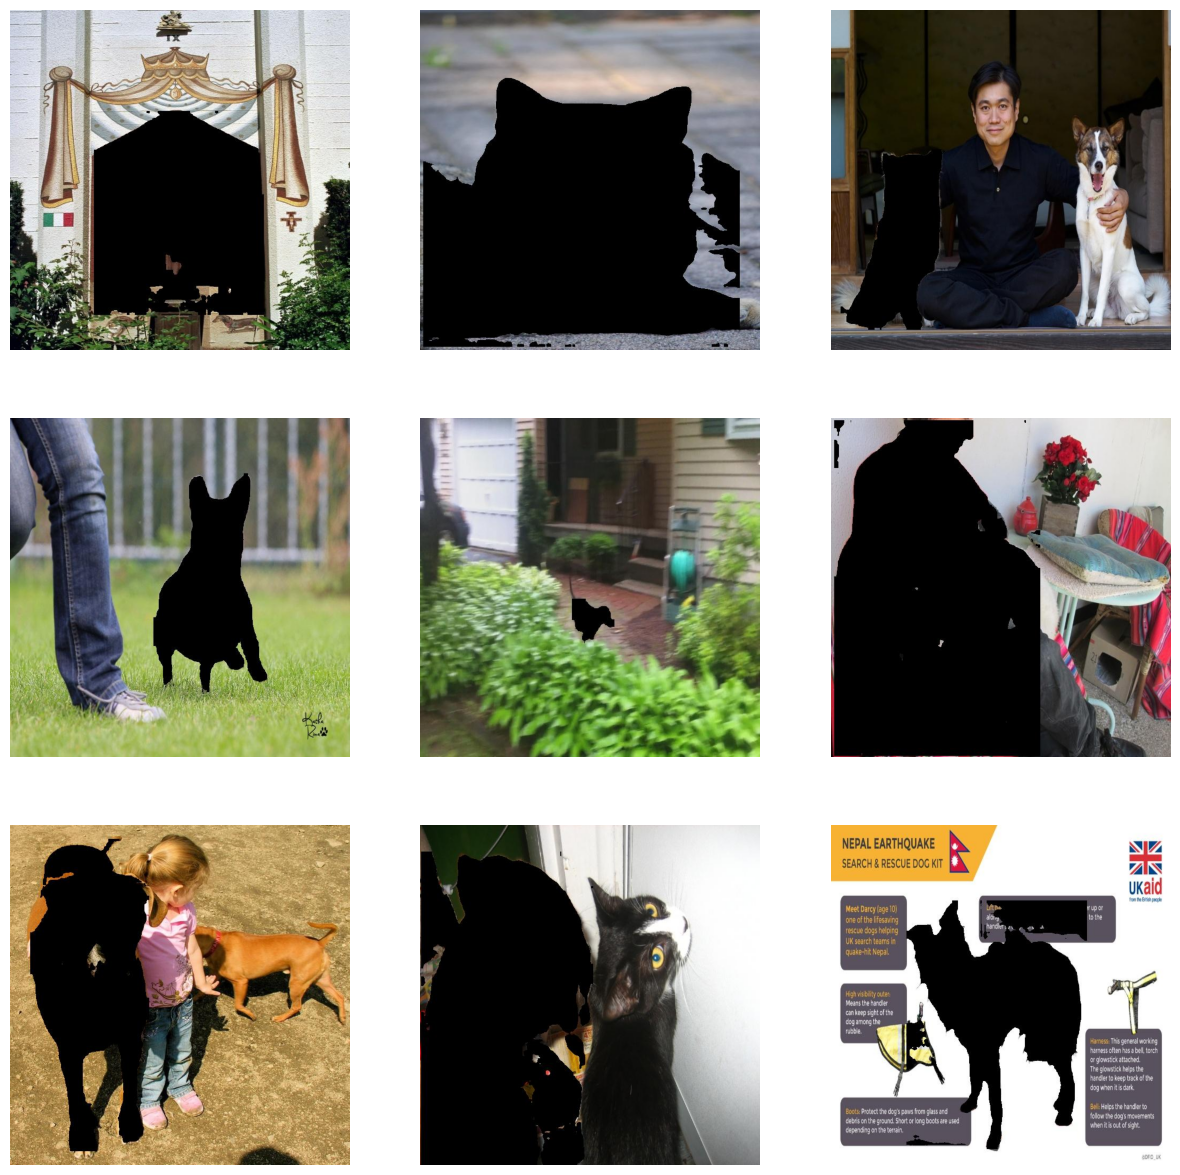

In [ ]:
view_random_image("input/train")